<blockquote>
    <h1>Exercise 6.9</h1>
    <p>In this exercise, we will predict the number of applications received using the other variables in the <code>College</code> data set.</p>
    <ol>
        <li>Split the data set into a training set and a test set.</li>
        <li>Fit a linear model using least squares on the training set, and report the test error obtained.</li>
        <li>Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.</li>
        <li>Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.</li>
        <li>Fit a PCR model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.</li>
        <li>Fit a PLS model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.</li>
        <li>Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?</li>
    </ol>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

<h3>Exercise 6.9.1</h3>
<blockquote>
    <i>Split the data set into a training set and a test set.</i>
</blockquote>

In [2]:
df = pd.read_csv("../../DataSets/College/College.csv")
assert not any(df['Unnamed: 0'].duplicated()) # check if duplicated in the 'Unnamed: 0' column
df = df.set_index('Unnamed: 0')
df.head()
df['Private'] = np.where(df['Private'] == 'Yes', 1, 0)  # convert categorical variable to quantative variable
df_Y = df[['Apps']]
df_X = df.drop('Apps', axis=1)
df_X_train, df_X_test = train_test_split(df_X, test_size=0.2, random_state=0)
df_Y_train, df_Y_test = train_test_split(df_Y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(df_X_train)
X_test = scaler.transform(df_X_test)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Unnamed: 0,,,,,,,,,,,,,,,,,,
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


<h3>Exercise 6.9.2</h3>
<blockquote>
    <i>Fit a linear model using least squares on the training set, and report the test error obtained.</i>
</blockquote>

In [3]:
results = {}
model = LinearRegression()
_ = model.fit(X_train, df_Y_train)
Y_pred = model.predict(X_test)
results['linear'] = mean_squared_error(df_Y_test, Y_pred)
f"mse = {results['linear']:.0f}"

'mse = 1176084'

<h3>Exercise 6.9.3</h3>
<blockquote>
    <i>Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.</i>
</blockquote>

'test error for best model is: 1111741 with lambda = 17.1'

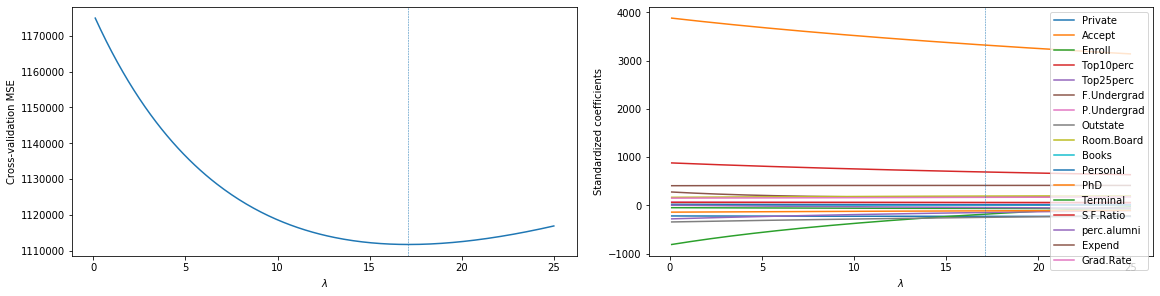

In [4]:
n, p = df_X.shape
columns = df_X.columns
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df_X)

stop = 25
num = 250
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
coef_arr = np.empty(shape=(lambda_arr.shape[0], p))
for index, lambda_ in enumerate(lambda_arr):
    model = Ridge(alpha=lambda_)
    _ = model.fit(X_train, df_Y_train)
        
    Y_pred = model.predict(X_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)
    
    model = Ridge(alpha=lambda_)
    _ = model.fit(X_standardized, df_Y) # fit with full data set
    coef_arr[index] = model.coef_

df_ridge_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_ridge_results.loc[df_ridge_results['MSE'].idxmin(), 'lambda']

df_coef = pd.DataFrame(coef_arr, columns=columns)

numberOfSubplots = 2
fig, [ax1, ax2] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_ridge_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

for column in columns:
    _ = ax2.plot(df_ridge_results['lambda'], df_coef[column], label=column)
    _ = ax2.set_ylabel('Standardized coefficients')
    _ = ax2.set_xlabel(r'$\lambda$')
    
_ = ax2.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax2.legend(loc='upper right')
_ = ax1.set_xlim(ax2.get_xlim())


results['ridge'] = df_ridge_results[df_ridge_results['lambda'] == lambda_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['ridge']:.0f} with lambda = {lambda_min_mse}"

<h3>Exercise 6.9.4</h3>
<blockquote>
    <i>Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.</i>
</blockquote>

'test error for best model is: 1137382 with lambda = 21.7'

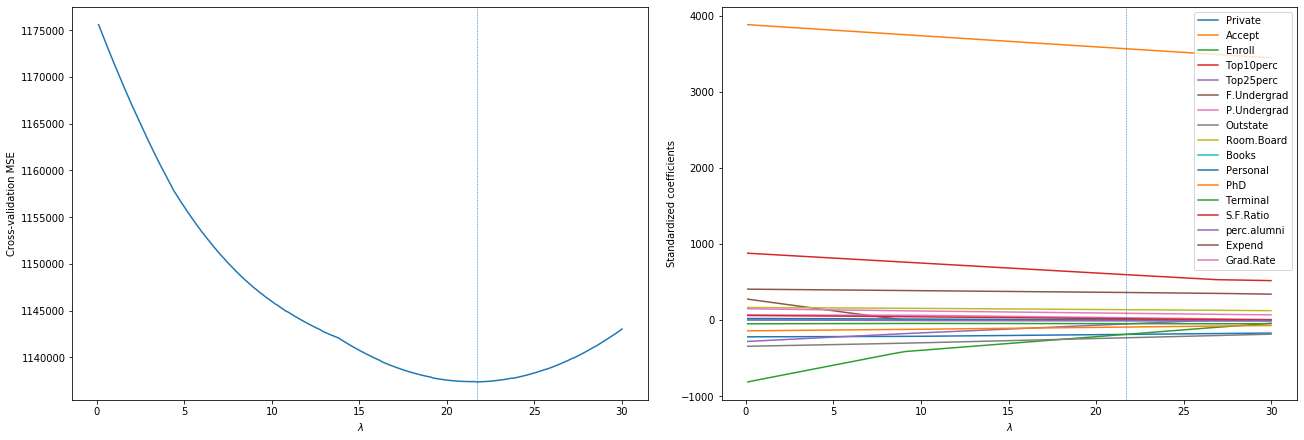

In [5]:
stop = 30
num = 300
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
coef_arr = np.empty(shape=(lambda_arr.shape[0], p))
for index, lambda_ in enumerate(lambda_arr):
    model = Lasso(alpha=lambda_)
    _ = model.fit(X_train, df_Y_train)
        
    Y_pred = model.predict(X_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)
    
    model = Lasso(alpha=lambda_)
    _ = model.fit(X_standardized, df_Y) # fit with full data set
    coef_arr[index] = model.coef_

df_lasso_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_lasso_results.loc[df_lasso_results['MSE'].idxmin(), 'lambda']

df_coef = pd.DataFrame(coef_arr, columns=columns)

numberOfSubplots = 2
fig, [ax1, ax2] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(9*numberOfSubplots, 6))

_ = df_lasso_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

for column in columns:
    _ = ax2.plot(df_lasso_results['lambda'], df_coef[column], label=column)
    _ = ax2.set_ylabel('Standardized coefficients')
    _ = ax2.set_xlabel(r'$\lambda$')
    
_ = ax2.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax2.legend(loc='upper right')
_ = ax1.set_xlim(ax2.get_xlim())

results['lasso'] = df_lasso_results[df_lasso_results['lambda'] == lambda_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['lasso']:.0f} with lambda = {lambda_min_mse}"

<h3>Exercise 6.9.5</h3>
<blockquote>
    <i>Fit a PCR model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.</i>
</blockquote>

'test error for best model is: 1159713 with 16 principal components'

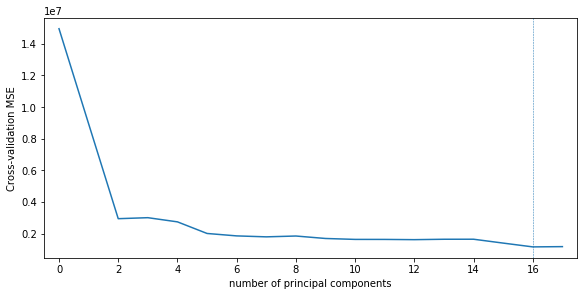

In [6]:
stop = df_X.shape[1]
num = df_X.shape[1] + 1
start = 0
m_components_arr = np.linspace(start=start, stop=stop, num=num, dtype=int)
mse_arr = np.empty(shape=m_components_arr.shape)
for index, m_components in enumerate(m_components_arr):
    if index == 0:
        Y_mean = df_Y.mean().iloc[0]
        mse_arr[index] = np.sum((df_Y - Y_mean)**2).iloc[0] / n
        continue
        
    # training the model with standardized training set
    pca_model = PCA(n_components=m_components)
    principalComponents_train = pca_model.fit_transform(X_train)
    linreg_model = LinearRegression()
    _ = linreg_model.fit(principalComponents_train, df_Y_train)
        
    # assessing performance of model on standardized test data
    principalComponents_test = pca_model.transform(X_test)
    Y_pred = linreg_model.predict(principalComponents_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)
    
df_pca_results = pd.DataFrame({
    'M': m_components_arr,
    'MSE': mse_arr,
})
m_min_mse = df_pca_results.loc[df_pca_results['MSE'].idxmin(), 'M']

numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_pca_results.plot(x='M', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=m_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel('number of principal components')
_ = ax1.set_xlim((-0.5, stop + 0.5))

results['pca'] = df_pca_results[df_pca_results['M'] == m_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['pca']:.0f} with {m_min_mse:.0f} principal components"

<h3>Exercise 6.9.6</h3>
<blockquote>
    <i>Fit a PLS model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.</i>
</blockquote>

'test error for best model is: 1578702 with 1 principal components'

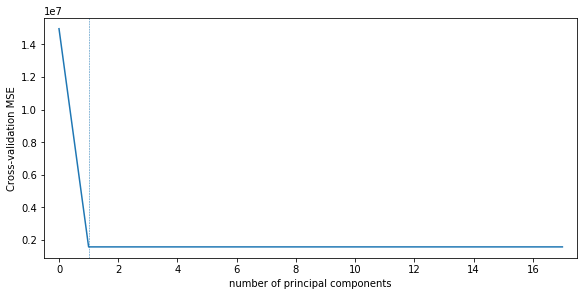

In [7]:
stop = df_X.shape[1]
num = df_X.shape[1] + 1
start = 0
m_components_arr = np.linspace(start=start, stop=stop, num=num, dtype=int)
mse_arr = np.empty(shape=m_components_arr.shape)
for index, m_components in enumerate(m_components_arr):
    if index == 0:
        Y_mean = df_Y.mean().iloc[0]
        mse_arr[index] = np.sum((df_Y - Y_mean)**2).iloc[0] / n
        continue
    
    pls = PLSRegression(n_components=3)
    _ = pls.fit(X_train, df_Y_train)
    Y_pred = pls.predict(X_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)
    
df_pls_results = pd.DataFrame({
    'M': m_components_arr,
    'MSE': mse_arr,
})
m_min_mse = df_pls_results.loc[df_pls_results['MSE'].idxmin(), 'M']

numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_pls_results.plot(x='M', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=m_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel('number of principal components')
_ = ax1.set_xlim((-0.5, stop + 0.5))

results['pls'] = df_pls_results[df_pls_results['M'] == m_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['pls']:.0f} with {m_min_mse:.0f} principal components"

<h3>Exercise 6.9.7</h3>
<blockquote>
    <i>Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?</i>
</blockquote>

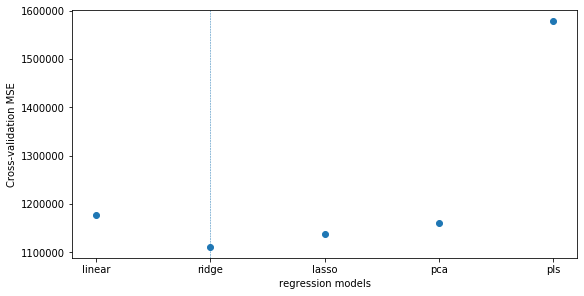

In [8]:
models = results.keys()
mse_results = results.values()
best_overall_model = min(results, key=results.get)

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax1.scatter(models, mse_results)
_ = ax1.axvline(x=best_overall_model, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel('regression models')